# This script is used to predict the Harpeth River heights based on the previous days heights and precipitation for the region. Both river data and precipitation data are from below Franklin, TN. This script uses two models to predict the river heights, one model is for the days in which it rains, and another is for the days it does not.



## Naming convention: 

## Water - River data, heights
## Precip - Weather data, precipitation
## PredictWeather - Weather Predictions
## PredictWater - Predicted water data
                       


### First section is used to import needed packages, connect to SQL DB, and get raw data

In [2]:
import pyodbc as pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

#Define figure size
plt.rcParams["figure.figsize"] = (18,10)

#Connect to SQL DB
connection = pyodbc.connect('Driver={SQL Server};'
                      'Server=DESKTOP-1SCLIO6;'
                      'Database=RiverHeightPrediction;'
                      'Trusted_Connection=yes;')


#Get Historical Data from SQL DB to create Model
Water_Precip = pd.read_sql_query('with River as '\
'( '\
'Select cast(datetime as date) as Date, Avg(GaugeHeight) as GaugeHeight, Avg(FlowRate) as FlowRate '\
'from harpethriverdatafranklin '\
'group by cast(datetime as date) '\
') '\

'select River.Date as Date,  GaugeHeight, Precipitation, lag(GaugeHeight) over(order by River.Date) as PrevGauge '\
'from River join weather on River.date = weather.date '\
'Where River.Date < \'2022-05-26\' '\
'order by river.date asc', connection)

#Get Data from SQL DB for predictions
#PredictionData = pd.read_sql_query('select * from WeatherPredicted', connection)

#Get Data from SQL DB for predictions
#WeatherPredicted = pd.read_sql_query('select * from WeatherPredicted', connection)

### Create data sets for splitting up for the ascending and descending models

In [8]:
#remove NA values created from the lag function
Water_Precip = Water_Precip.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

#Add column of derivative of gaugeheight
Water_Precip['DeltaGauge'] = Water_Precip.GaugeHeight - Water_Precip.PrevGauge

#Filter out non-precip days for ascending model
Water_Precip_AscendingWater = Water_Precip[Water_Precip["Precipitation"] > 0]

#Filter out precip days for descendign model
Water_Precip_DescendingWater = Water_Precip[Water_Precip["Precipitation"] == 0]

In [9]:
X_desc = Water_Precip_DescendingWater[['PrevGauge']]
y_desc = Water_Precip_DescendingWater['GaugeHeight']

X_asc = Water_Precip_AscendingWater[['Precipitation']]
y_asc = Water_Precip_AscendingWater['DeltaGauge']

Text(0, 0.5, 'GaugeHeight')

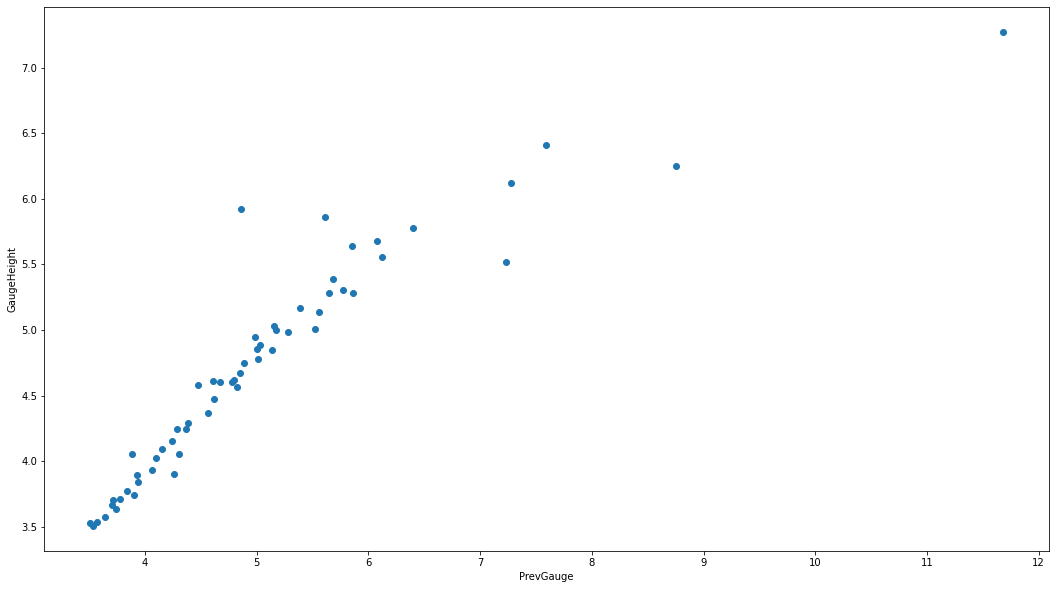

In [10]:
plot = plt.scatter(X_desc, y_desc)
plt.xlabel('PrevGauge')
plt.ylabel('GaugeHeight')

Text(0, 0.5, 'DeltaGauge')

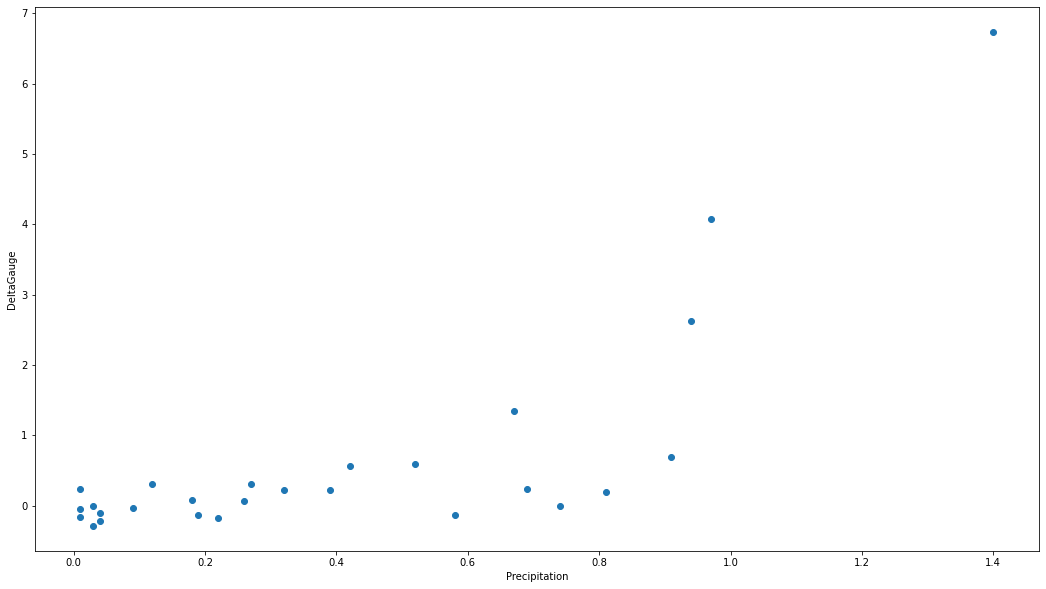

In [11]:
plot = plt.scatter(X_asc, y_asc)
plt.xlabel('Precipitation')
plt.ylabel('DeltaGauge')

## Run descending regression

In [12]:
#Run polynomial regression with order of 2
polyregdesc=make_pipeline(PolynomialFeatures(2),LinearRegression())
polyregdesc.fit(X_desc,y_desc)

print(polyregdesc.score(X_desc, y_desc))

0.9214543250421483


## Run  ascending regression

In [13]:
#Run polynomial regression with order of 2
polyregasc=make_pipeline(PolynomialFeatures(2),LinearRegression())
polyregasc.fit(X_asc,y_asc)

print(polyregasc.score(X_asc, y_asc))

0.841274777660252


## Use regressions to predict water data

In [14]:
WaterPredicted = Water_Precip[['Date', 'GaugeHeight', 'Precipitation']]
WaterPredicted["PrevGauge"] = None
WaterPredicted["PredictedGauge"] = None

WaterPredicted = WaterPredicted.to_numpy()

C:\Users\ryder\AppData\Local\Temp/ipykernel_20404/2555883326.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WaterPredicted["PrevGauge"] = None


In [15]:
#Loop through entire data set and use models to predict gauge height for that specific day
rows, cols = WaterPredicted.shape
FitValues = np.empty([1, 1])
i = 0
#Set this to seed value - Gauge height on 2022-03-02
PrevGauge = 6.655

while(i < rows):
    WaterPredicted[i,3] = PrevGauge
    
    #Ascending regression, pass Precip to regression, find DeltaG, add to prevgauge
    if WaterPredicted[i,2] != 0:
            FitValues[0,0] = WaterPredicted[i,2]
            DeltaG = polyregasc.predict(FitValues)
            WaterPredicted[i,4] = PrevGauge + DeltaG[0]
    
    #Descending regression, pass prevgauge to reg, find GaugeHeight
    else:
            FitValues[0,0] = WaterPredicted[i,3]
            GaugeHeight = polyregdesc.predict(FitValues)
            WaterPredicted[i,4] = GaugeHeight
    
    PrevGauge = WaterPredicted[i,4]
    i+=1

In [16]:
WaterPredicted = pd.DataFrame(WaterPredicted, columns = ['Date','GaugeHeight','Precip','Prevgauge', 'PredictedGauge'])

Text(0, 0.5, 'GaugeHeight')

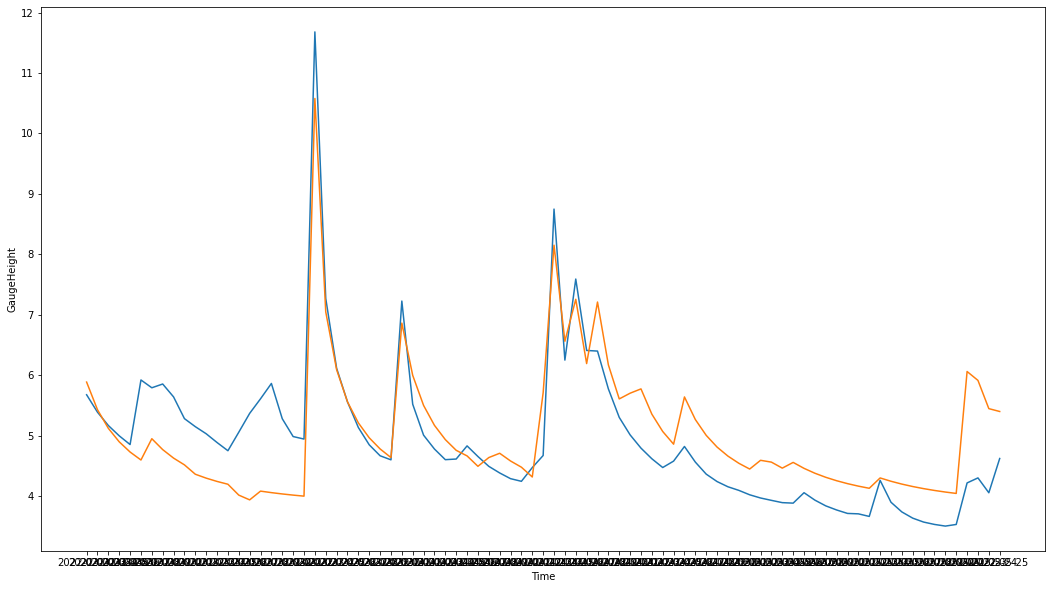

In [17]:
plot = plt.plot(WaterPredicted['Date'], WaterPredicted['GaugeHeight'])
plot = plt.plot(WaterPredicted['Date'], WaterPredicted['PredictedGauge'])
plt.xlabel('Time')
plt.ylabel('GaugeHeight')

# This next section is used to predict iteratively using the model we created above, using 2021 data

In [88]:
Water_Precip_2021 = pd.read_sql_query('with River as '\
'( '\
'Select cast(datetime as date) as Date, Avg(GaugeHeight) as GaugeHeight, Avg(FlowRate) as FlowRate '\
'from harpethriverdatafranklin2021 '\
'group by cast(datetime as date) '\
') '\

'select River.Date as Date,  GaugeHeight, Precipitation, lag(GaugeHeight) over(order by River.Date) as PrevGauge '\
'from River join franklinweather2021 on River.date = franklinweather2021.date '\
'Where River.Date > \'2021-04-01\'' 
'order by river.date asc', connection)

In [93]:
WaterPredicted2021 = Water_Precip_2021[['Date', 'GaugeHeight', 'Precipitation']]
WaterPredicted2021["PrevGauge"] = None
WaterPredicted2021["PredictedGauge"] = None

WaterPredicted2021 = WaterPredicted2021.to_numpy()

In [94]:
#Loop through entire data set and use models to predict gauge height for that specific day
rows, cols = WaterPredicted2021.shape
FitValues = np.empty([1, 1])
i = 0
#Set this to seed value - Gauge height on 2021-04-01
PrevGauge = 10.5

while(i < rows):
    WaterPredicted2021[i,3] = PrevGauge
    
    #Ascending regression, pass Precip to regression, find DeltaG, add to prevgauge
    if WaterPredicted2021[i,2] != 0:
            FitValues[0,0] = WaterPredicted2021[i,2]
            DeltaG = polyregasc.predict(FitValues)
            WaterPredicted2021[i,4] = PrevGauge + DeltaG[0]
    
    #Descending regression, pass prevgauge to reg, find GaugeHeight
    else:
            FitValues[0,0] = WaterPredicted2021[i,3]
            GaugeHeight = polyregdesc.predict(FitValues)
            WaterPredicted2021[i,4] = GaugeHeight
    
    PrevGauge = WaterPredicted2021[i,4]
    i+=1

In [95]:
WaterPredicted2021 = pd.DataFrame(WaterPredicted2021, columns = ['Date','GaugeHeight','Precip','Prevgauge', 'PredictedGauge'])

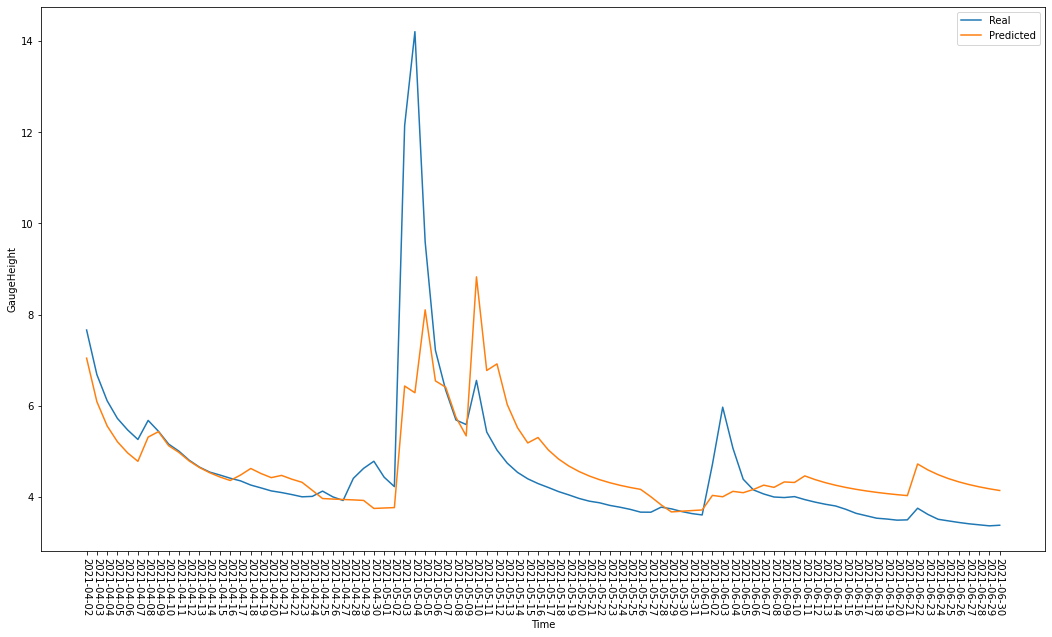

In [100]:
plot = plt.plot(WaterPredicted2021['Date'], WaterPredicted2021['GaugeHeight'])
plot = plt.plot(WaterPredicted2021['Date'], WaterPredicted2021['PredictedGauge'])
plt.xlabel('Time')
plt.ylabel('GaugeHeight')
plt.xticks(rotation = -90)
plt.legend(['Real', 'Predicted'])

In [97]:

pd.set_option('display.max_rows', 1000)
WaterPredicted2021

,Date,GaugeHeight,Precip,Prevgauge,PredictedGauge
0,2021-04-02,7.662604,0.0,10.5,[7.044748778137994]
1,2021-04-03,6.685376,0.0,[7.044748778137994],[6.091506998249545]
2,2021-04-04,6.111398,0.0,[6.091506998249545],[5.559623784169735]
3,2021-04-05,5.724062,0.0,[5.559623784169735],[5.212302272062017]
4,2021-04-06,5.470104,0.0,[5.212302272062017],[4.965960337550567]
5,2021-04-07,5.26117,0.0,[4.965960337550567],[4.781881490234099]
6,2021-04-08,5.679362,0.63,[4.781881490234099],[5.313399520221891]
7,2021-04-09,5.441667,0.02,[5.313399520221891],[5.432454215478971]
8,2021-04-10,5.158958,0.0,[5.432454215478971],[5.123897185613542]
9,2021-04-11,5.004062,0.18,[5.123897185613542],[4.976781674613262]
